# Chapter 3: Clustering

Clustering is a very common form of unsupervised learning. There are two main kinds of methods.

In the **first approach**, the input is a set of data samples $$ \mathcal{D} = \{x_n : n = 1 : N\},$$ where $x_n \in \mathbb{R}^{D}.$ 

In the **second approach**, the input is an $N \times N$ pairwise dissimilarity metric $D_{ij} > 0 $ (also called distance metric) tha tdescribes the pairwise distinction between $M$ objects. It is a square symmetrical $M \times M$ matrix with the (ij)th element equal to the value of a chosen measure of distinction between the (i)th and the (j)th object. In both cases, the goal is to assign similar data points to the same cluster. 

---

## 3.1 Evaluating the output of clustering methods

Clustering is an unsupervised learning technique, so it is hard to evaluate the quality of the output
of any given method. If we have labeled data for some of the data, we can use the similarity (or equality)
between the labels of two data points as a metric for determining if the two inputs “should” be
assigned to the same cluster or not. If we don’t have labels, but the method is based on a generative
model of the data, we can use log likelihood as a metric. 

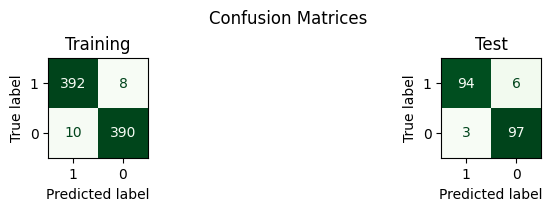

In [2]:
%run 'make_moons.py'

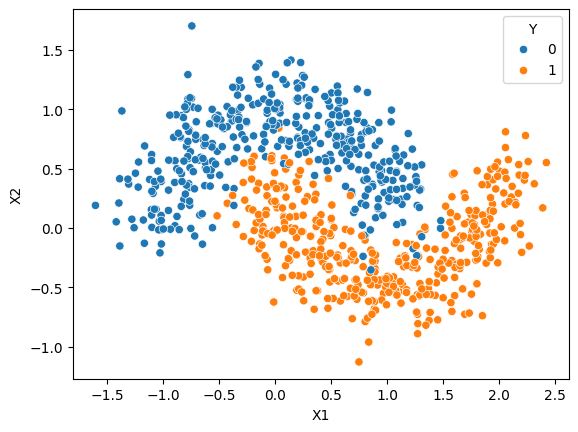

In [3]:
import seaborn as sns
sns.scatterplot(dfTR, x = "X1", y = "X2", hue="Y");

**Purity**

 Purity: Let $N_{ij}$ be the number of objects in cluster $i$ that belong to class $j$, and let $N_{i} = \sum_{j=1}^{C}N_{ij}$ be the total number of objects in cluster $i$. Define $p_{ij} = \frac{N_{ij}}{N_{i}}$. Purity of a cluster is then the $p_{i} = \text{max}_{j} p_{ij}$, and the overall purity of a clustering is: 
 $$p = \sum_{i}\frac{N_{i}}{N} p_{i}$$

In [4]:
import numpy as np
from sklearn import metrics

def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix) 

In [5]:
purity_score(dfTR_eval['Y'], dfTR_eval['Y_knn_pred'])

0.9775

The purity ranges between 0 (bad) and 1 (good). However, we can trivially achieve a purity of 1 by
putting each object into its own cluster, so this measure does not penalize for the number of clusters.

**Rand Index**

Let U and V be two different partitions of the N data points. For
example, U might be the estimated clustering and V is reference clustering derived from the class
labels. Now define a $2\times2$ contingency table, containing the following numbers: 

- TP: both in U and V.
- TN different clusters in U and V.
- FN: different in U but same in V.

- FP: same in U but different in V. 

A common summary statistic is the Rand index: $$R = \frac{TP+ TN}{TP + FP + TN + FN}$$
This can be interpreted as the fraction of clustering decisions that are correct. Clearly $0 \leq R \leq 1$.  
The Rand index weights false positives and false negatives equally.

In [7]:
from sklearn.metrics.cluster import rand_score
rand_score(dfTR_eval['Y'], dfTR_eval['Y_knn_pred'])

0.9559574468085107

**Adjusted Rand index**

The Rand index only achieves its lower bound of $0$ if TP = TN = 0, which is a rare event. One
can define an adjusted Rand index:

$$ARI = \frac{\text{index} - \text{expected index}}{\text{max index} - \text{expected index}}$$

In [8]:
from sklearn.metrics.cluster import adjusted_rand_score
adjusted_rand_score(dfTR_eval['Y'], dfTR_eval['Y_knn_pred'])

0.9119147583986604

ARI may take a negative value for especially discordant labelings that are a worse choice than the expected value of random labels. In contrast to the normalized mutual information score (see below), the ARI does not require the knowledge of the true number of clusters. It adjusts for chance agreement and is less sensitive to the absolute sizes of the clusters.

**Mutual Information**

Another way to measure cluster quality is to compute the mutual information between two candidate
partitions U and V. To do this, let $p_{\text{UV}}(i, j) = \frac{|u_{i}\cap v_{j}|}{N}$ be the probability that a randomly chosen object belongs to cluster $u_{i}$ in U and $v_{j}$ in V. Also, let $p_{U}(i) = \frac{|u_{i}|}{N}$ be the probability that a randomly chosen object belongs to cluster $u_{i}$ in U; define $p_{V}(j) = \frac{|v_{J}|}{N}$ be the probability that a randomly chosen object belongs to cluster $v_{j}$ in V. Then we have: 

$$\mathbb{I}(U,V) = \sum_{i=1}^{R}\sum_{j=1}^{C} p_{\text{UV}}(i, j) \text{log} \frac{p_{UV}(i, j)}{p_{U}(i)p_{V}(j)}$$

This lies between $0$ and $\text{min}\{\mathbb{H}(U), \mathbb{H}(V)\}$. Unfortunately, the maximum value can be achieved
by using lots of small clusters, which have low entropy. To compensate for this, we can use the
normalized mutual information which lies between $0$ and $1$.  

$$N\mathbb{I}(U,V) = \frac{2\mathbb{I}(U,V)}{\mathbb{H}(U) + \mathbb{H}(V)}$$

In [9]:
from sklearn.metrics.cluster import normalized_mutual_info_score
normalized_mutual_info_score(dfTR_eval['Y'], dfTR_eval['Y_knn_pred'])

0.8449388479311319

- A score close to 1 indicates that the clusterings are very similar.
- A score close to 0 indicates that the clusterings are dissimilar.

Therefore, a normalized mutual information score closer to 1 indicates that the clustering is good and there is a high degree of agreement between the true labels and the predicted labels. In other words, the clusters found by the algorithm closely match the true underlying clusters.

---

## 3.2 Hierarchical Agglomerative Clustering

A common form of clustering is known as **hierarchical agglomerative clustering or HAC**. 
The input to the algorithm is an $N \times N$ dissimilarity matrix $D_{ij}\geq0$, and the output is a tree structure
in which groups i and j with small disimilarity are grouped together in a hierarchical fashion.


For example, consider the set of $5$ inputs points below in $x_n \in \mathbb{R}^2$. We will use **city
block distance** between the points to define the dissimilarity, i.e. 

$$d_{ij} = \sum_{k=1}^{2}|x_{ik}-x_{jk}|$$

We start with a tree with N leaves, each corresponding to a cluster with a single data point. Next
we compute the pair of points that are closest, and merge them.

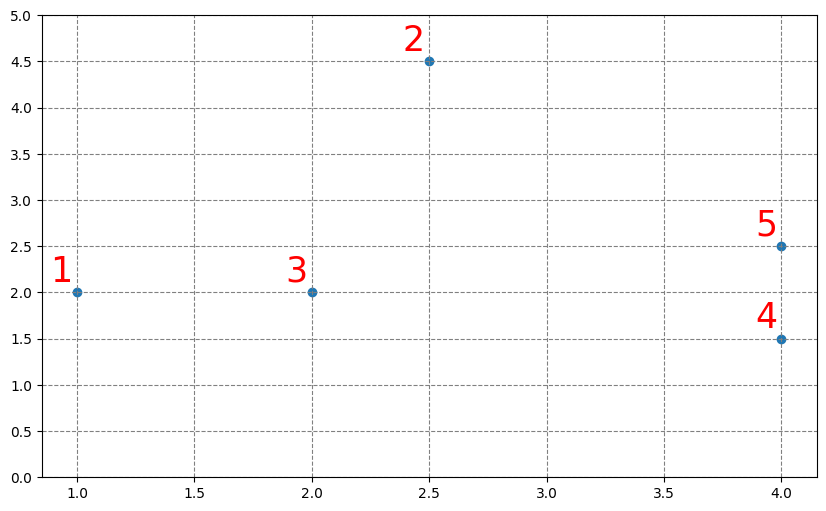

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

X = np.array([[1, 2],[2.5, 4.5],[2, 2],[4, 1.5],[4, 2.5],])

labels = range(1, 6)
plt.figure(figsize=(10, 6))
plt.yticks(np.linspace(0, 5, 11))
plt.ylim(0, 5)
plt.grid(color="gray", linestyle="dashed")
plt.scatter(X[:, 0], X[:, 1], label="True Position")
for label, x, y in zip(labels, X[:, 0], X[:, 1]):
    plt.annotate(
        label, xy=(x, y), xytext=(-3, 3), textcoords="offset points", ha="right", va="bottom", fontsize=25, color="red"
    )

We see that (1,3) and (4,5) are
both distance 1 apart, so they get merged first. We then measure the dissimilarity between the sets
{1,3}, {4,5} and {2} using some measure (details below), and group them, and repeat. The result is 
a binary tree known as a dendrogram. By cutting this tree at different heights, we can induce a different number of (nested) clusters.

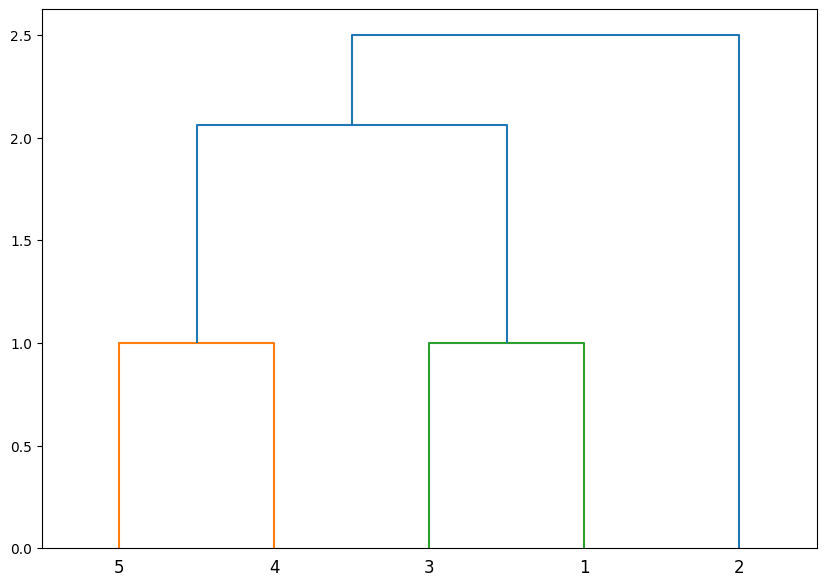

In [11]:
linked = linkage(X, 'single')
labelList = range(1, 6)
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=labelList, distance_sort='descending', show_leaf_counts=True)
plt.show()

In [13]:
# (n-1)x 4
linked.shape

(4, 4)

In [17]:
linked[3]

array([1. , 7. , 2.5, 5. ])

In [12]:
# data 1, data 2, distance, num of obser in new cluster


`The Algorithm`

1. Initialise clusters as singletons: **for** $i \leftarrow 1 $ to $n$ do $C_{i} \leftarrow \{i\}$
2.
3. Initialise set of clusters available for merging: $S \leftarrow \{1, \cdots, n\}$; **repeat**
   1. Pick $2$ most similar clusters to merge: $(j,k) \leftarrow arg\text{min}_{j,k \in S}d_{j,k}$
   2. Create new cluster $C_{l} \leftarrow C_{j} \cup C_{k}$
   3. Mark $j$ and $k$ as unavailable: $S \leftarrow S \backslash \{j,k\}$
   4. **if** $C_{l} \neq \{1, \cdots, n\}$ **then**
      1. Mark $l$ as available, $S \leftarrow S\cup \{l\}$.
   5. **for each** $i \in S$ **do**
      1. Update dissimilarity matrix $d(i,l)$
4. **until** *no more clusters are available for merging*

---

## 3.2.1. Single link

In single link clustering, also called nearest neighbor clustering, the distance between two
groups G and H is defined as the distance between the two closest members of each group: 

$$d_{SL}(U,V) = min_{i\in G,j \in H} d_{i, j}$$

The tree built using single link clustering is a minimum spanning tree of the data, which is a tree
that connects all the objects in a way that minimizes the sum of the edge weights (distances). To
see this, note that when we merge two clusters, we connect together the two closest members of
the clusters; this adds an edge between the corresponding nodes, and this is guaranteed to be the “lightest weight” edge joining these two clusters. And once two clusters have been merged, they will
never be considered again, so we cannot create cycles. 


In [18]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist

clustering = AgglomerativeClustering(linkage='single', metric='manhattan').fit(dfTR)
cityDist = pdist(dfTR, 'cityblock')

In [19]:
adjusted_rand_score(dfTS_eval['Y'], clustering.fit_predict(dfTS_eval))

0.827232603488166

In [20]:
normalized_mutual_info_score(dfTS_eval['Y'], clustering.fit_predict(dfTS_eval))

0.7386721149855451

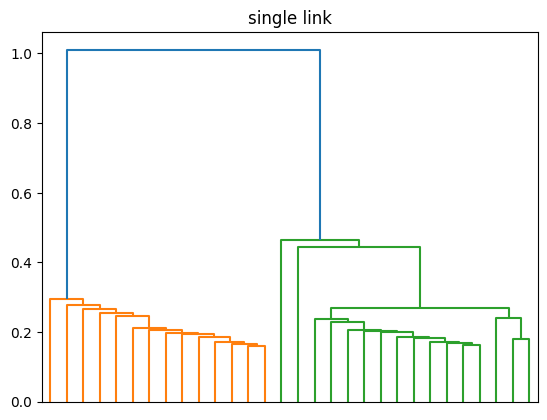

In [26]:
import scipy 

plt.figure()
Z = scipy.cluster.hierarchy.linkage(cityDist, 'single')
scipy.cluster.hierarchy.dendrogram(Z, truncate_mode='lastp')
plt.title('single link')
plt.tick_params(labelbottom=False)
plt.show()

---

## 3.2.2. Complete link 

In complete link clustering, also called furthest neighbor clustering, the distance between
two groups is defined as the distance between the two most distant pairs:

$$ d_{CL}(G,H) = \text{max}_{i\in G, j \in H} d_{i,j}$$

Single linkage only requires that a single pair of objects be close for the two groups to be considered
close together, regardless of the similarity of the other members of the group. Thus clusters can be
formed that violate the compactness property, which says that all the observations within a group
should be similar to each other. Complete linkage represents the opposite extreme: two groups are
considered close only if all of the observations in their union are relatively similar. This will tend
to produce clusterings with small diameter, i.e., compact clusters.

In [32]:
clustering = AgglomerativeClustering(n_clusters = 3, linkage='complete', metric='euclidean').fit(dfTR)
cityDist = pdist(dfTR, 'cityblock')

In [33]:
np.unique(clustering.labels_)

array([0, 1, 2])

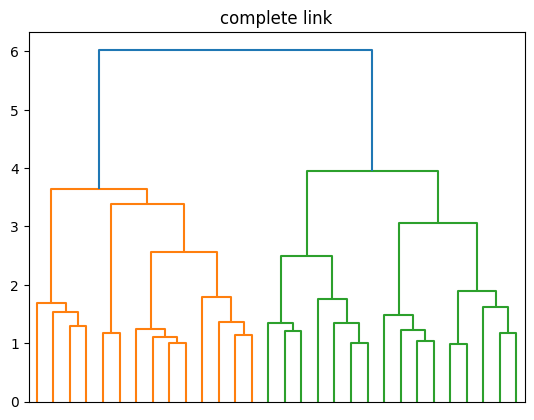

In [34]:
plt.figure()
Z = scipy.cluster.hierarchy.linkage(cityDist, 'complete')
scipy.cluster.hierarchy.dendrogram(Z, truncate_mode='lastp')
plt.title('complete link')
plt.tick_params(labelbottom=False)
plt.show()

---

## 3.2.3. Average link 

In practice, the preferred method is average link clustering, which measures the average distance
between all pairs:

$$d_{avg}(G,H)= \frac{1}{n_{G}n_{H}} \sum_{i\in G}\sum_{j\in H} d_{i,j},$$
where $n_{G}$ and $n_{H}$ are the elements in the groups $G$ and $H$. 

In [36]:
clustering = AgglomerativeClustering(linkage='average', metric='manhattan').fit(dfTR)
cityDist = pdist(dfTR, 'cityblock')

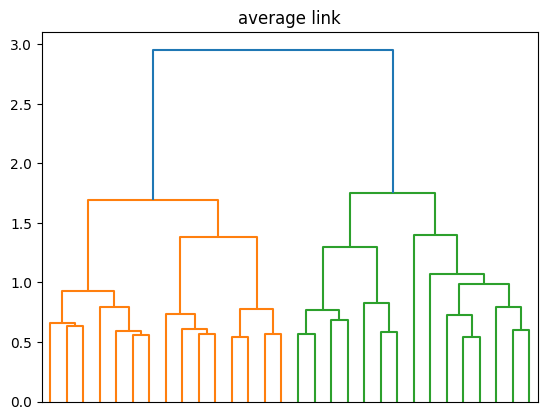

In [37]:
plt.figure()
Z = scipy.cluster.hierarchy.linkage(cityDist, method='average')
scipy.cluster.hierarchy.dendrogram(Z, truncate_mode='lastp')
plt.title('average link')
plt.tick_params(labelbottom=False)
plt.show()

Average link clustering represents a compromise between single and complete link clustering. It
tends to produce relatively compact clusters that are relatively far apart. However, since it involves averaging of the $d_{i,j}$, any change to the measurement scale can change the result. In contrast, single linkage and complete linkage are invariant to monotonic transformations of $d_{i,j}$, since they leave the relative ordering the same.

---

## 3.2.4. Ward Linkage

Ward proposed that the loss of information that occurs when integrating the different individuals in clusters can be measured through the total sum of the squares of the deviations between each point (individual) and the mean of the cluster in which it is integrated.In order for the clustering process to be optimal, in the sense that the groups formed do not distort the original data, he proposed the following strategy:
At each step of the analysis, consider the possibility of the union of each pair of groups and opt for the merger of those two groups that least increase the sum of squares of the deviations when joined.


$$d_{ward}(u,v) = \sqrt{\frac{|v| + |s|}{T}d(v,s)^{2} + \frac{|v| + |t|}{T}d(v,t)^{2} - \frac{|v|}{T}d(s,t)^{2}}$$

where $u$ is the newly joined cluster consisting of clusters $s$ and $t$, $v$ is an unused cluster in the forest, and $T = |v| + |s| + |t|$ is the cardinality. 

Ward's method is one of the most widely used in practice; it has almost all the advantages of the mean method and is usually more discriminative in determining the levels of clustering since *it minimizes the variance of the clusters being merged*.

In [43]:
clustering = AgglomerativeClustering(linkage='ward', metric='euclidean').fit(dfTR)
cityDist = pdist(dfTR, 'euclidean')

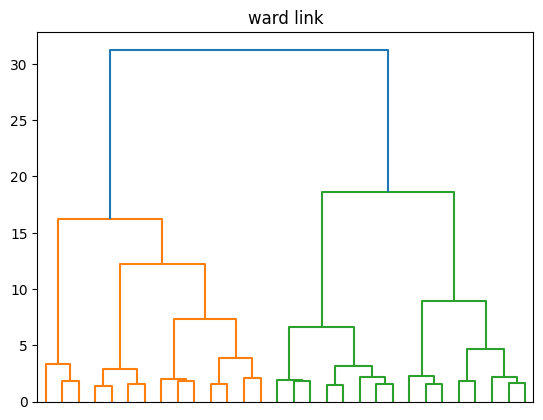

In [44]:
plt.figure()
Z = scipy.cluster.hierarchy.linkage(cityDist, method='ward')
scipy.cluster.hierarchy.dendrogram(Z, truncate_mode='lastp')
plt.title('ward link')
plt.tick_params(labelbottom=False)
plt.show()

## Comparing clustering algorithms

[Code taken from sklearn](https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html)

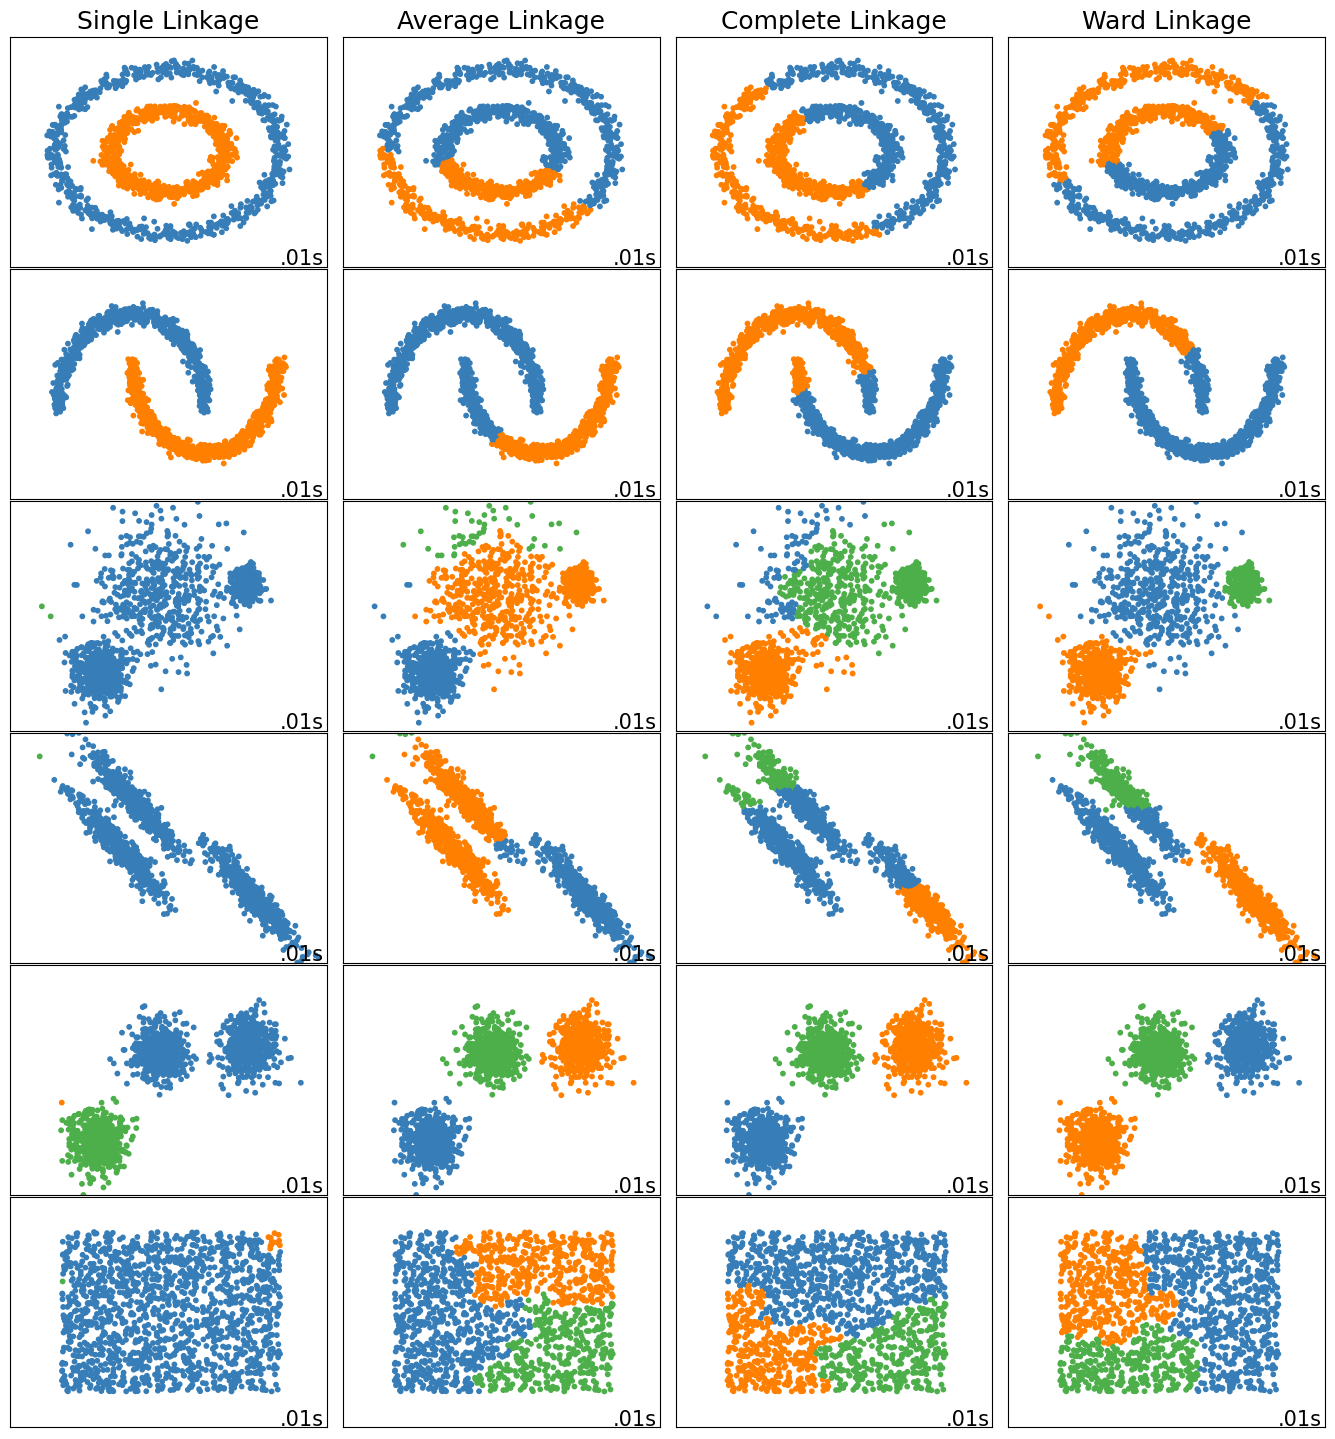

In [45]:
%run -i 'plot_linkage_comparison.py'

---

## 3.2. K MEANS CLUSTERING

There are several problems with hierarchical agglomerative clustering. First, it takes $O(N^3)$ time (for the average link method), making it hard to apply to big datasets. Second, it assumes that a dissimilarity matrix has already been computed, whereas the notion of “similarity” is often unclear and needs to be learned. Third, it is just an algorithm, not a model, and so it is hard to evaluate how good it is. That is, there is no clear objective that it is optimizing. 

In this section, we discuss the **K-means algorithm**, which addresses these issues: 

- First, it runs in $O(NKT)$ time, where T is the number of iterations. 

- Second, it computes similarity in terms of Euclidean distance to **learned cluster centers $μ_{k} \in \mathbb{R}^{D}$**, rather than requiring a dissimilarity matrix. 

- Third, **it optimizes a well-defined cost function**, as we will see.

---

We assume there are $K$ cluster centers $μ_{k} \in \mathbb{R}^{D}$, so we can cluster the data by assigning each data point $x_{n} \in \mathbb{R}^{D}$ to it closest center:

$$ z_{n}^{*} = \text{argmin}_{k} || \vec{x}_{n} - \vec{\mu}_{k} ||^{2}$$

Of course, we don’t know the cluster centers, but we can estimate them by computing the average value of all points assigned to them:

$$ \vec{\mu}_{k} = \frac{1}{N_{k}} \sum_{n:z_{n} = k} \vec{x}_{n}$$

We can then iterate these steps to convergence. 

More formally, we can view this as finding a local minimum of the following cost function, known as the **distortion**: 

$$ J(\mathbf{M}, \mathbf{Z}) = \sum_{n=1}^{N} || \vec{x}_{n} - \vec{\mu}_{z_{n}} ||^{2} = || \mathbf{X} - \mathbf{Z}\mathbf{M}^{T} || ^{2} $$

where $\mathbf{X} \in \mathbb{R}^{N \times D}$, $\mathbf{Z} \in [0, 1]^{N \times K}$, and $\mathbf{M} \in \mathbb{R}^{D\times K}$ containes the clusters centers $\vec{\mu}_{k}$ in its columns. 

K-Means optimises this using alternating minimisation. From a theoretical perspective, finding the optimal solution for a clustering problem is particularly difficult (NP-hard). 

Thus, all algorithms are only approximations of the optimal solution. The k-means algorithm, is an iterative process that refines the solution until it converges to a local optimum.

---

`The Algorithm`

1. Specify the number $k$ of clusters to assign. 
2. Randomly initialise $k$ centroids.
3. **repeat**
   1. **expectation**: Assign each point to its closest centroid. 
   2. **maximisation**: Compute the new centroid (mean) of each cluster.
4. **until** The centroid positions do not change.


---

## Example: 

In [46]:
import numpy as np

blob1 = np.random.multivariate_normal(mean=[-3, 3], cov=[[3, 2], [2, 3]], size=100)
blob2 = np.random.multivariate_normal(mean=[5, 2], cov=[[2, 1], [1, 2]], size=100)
blob3 = np.random.multivariate_normal(mean=[0, -3], cov=[[2, 0], [0, 2]], size=100)
data = np.vstack([blob1, blob2, blob3])

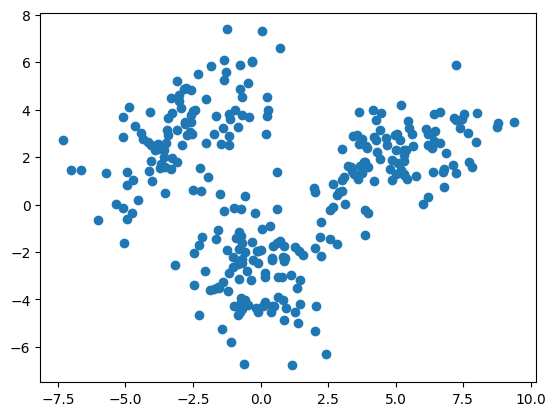

In [47]:
plt.scatter(data[:, 0], data[:, 1])

- **Initialization**: Often, there is no good prior knowledge about the location of the centroids. An effortless way to start is to define the centroids by randomly selecting  data points from the dataset (Forgy method).

In [48]:
def pick_centroids(data, k):
    indexes = np.random.choice(len(data), size=k, replace=False)
    centroids = data[indexes]
    return centroids

- **Assignment**: For each data point, the distance to all centroids is computed. The data points belong to the cluster represented by the closest centroid. This is called a hard assignment because the data point belongs to one and only one cluster.

In [49]:
def assign_cluster(data, centroids):
    # Pairwise squared L2 distances. Shape [n, k]
    distances = ((data[:, np.newaxis] - centroids)**2).sum(axis=2)
    # find closest centroid index. Shape [n]
    clusters = np.argmin(distances, axis=1)
    return clusters

- **Update**: Given all the points assigned to a cluster, the mean position is computed and defines the new location of the centroid. All centroids are updated simultaneously. 


In [50]:

def update_centroids(data, clusters, k):
    # Mean positions of data within clusters
    centroids = [np.mean(data[clusters == i], axis=0) for i in range(k)]
    return np.array(centroids)

In [51]:
class KMEANS:
    def __init__(self, k):
        self.k = k
        
    def fit(self, data, steps=20):
        self.centroids = pick_centroids(data, self.k)
        for step in range(steps):
            clusters = assign_cluster(data, self.centroids)
            self.centroids = update_centroids(data, clusters, self.k)
            
    def predict(self, data):
        return assign_cluster(data, self.centroids)
    

In [52]:
kmeans = KMEANS(k=3)
kmeans.fit(data)
clusters = kmeans.predict(data)

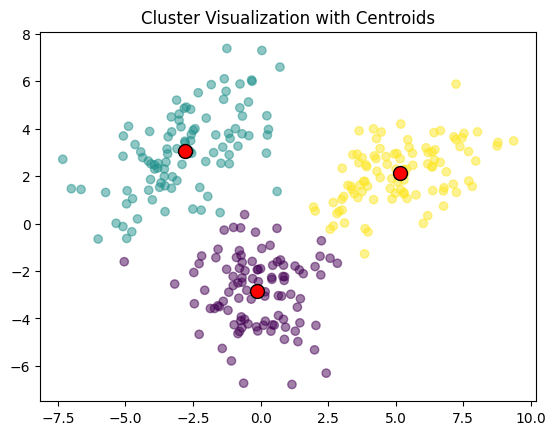

In [53]:
import matplotlib.pyplot as plt
plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.5) 
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c="red", s=100, edgecolor='black', label='Centroids')
plt.title('Cluster Visualization with Centroids')  
plt.grid(False)
plt.show()

It is possible to visualize the decision boundaries. 

To do so, we can generalize the definitions of the groups and include all possible elements rather than only observed data points. 

These are called **Voronoi cells**, and they look like this:

In [54]:
def plot_decision_boundaries(clusterer, X, resolution=1000):
    plt.figure()
    mins = X.min(axis=0) - 0.2
    maxs = X.max(axis=0) + 0.2
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.title('Cluster Visualization with Voronoi cells') 
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors="k")
    plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.5) 
    plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c="red", s=100, edgecolor='black', label='Centroids')
    plt.show()
    

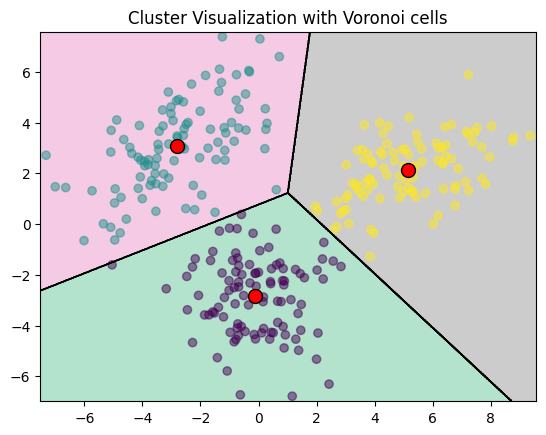

In [55]:
plot_decision_boundaries(kmeans, data)

### *Sklearn Implementation*

https://www.youtube.com/watch?v=4qJWhvFQb9g&t=0s

In [56]:
from sklearn.cluster import KMeans
import numpy as np

#class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', 
#                    n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd')
# For large scale learning (say n_samples > 10k) MiniBatchKMeans is probably much faster than the default batch implementation.

kmeans_sklearn = KMeans(n_clusters=2, init='random', n_init=10, random_state=29).fit(data)
kmeans_sklearn.predict(data)
kmeans_sklearn.cluster_centers_

array([[-1.50848997,  0.04797996],
       [ 5.03909364,  2.16904612]])

In [58]:
np.unique(kmeans_sklearn.labels_)

array([0, 1], dtype=int32)

### Selecting the number of clusters.

In this section, we discuss how to choose the number of clusters K in the K-means algorithm and
other related methods.

- **Silhouette coefficient**
 
A common heuristic method for picking the number of clusters in a K-means clustering model. This is designed to work for spherical (not elongated) clusters. 
First we define the **silhouette coefficient** of an instance $i$ to be: 

$$sc(i) = \frac{b_{i} - a_{i}}{\text{max}(a_{i}, b_{i})}$$

where $a_{i}$ is the mean distance to the other instances in the next closes cluster, thus it is a measure of compactness of the $i$'s cluster, and $b_{i}$ is a measure of distance between the clusters. 

The silhouette coefficient varies from $-1$ to $+1$ where: 
- $1$ means instance is close to all the memebers of tis cluster and far from other clusters. 
- $0$ means it is close to a cluster boundary. 
- $-1$ means it may be in the wrong cluster. 


In [59]:
from matplotlib import cm
import matplotlib as mpl
import matplotlib.pyplot as plt

In [60]:
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)


In [61]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

In [66]:
if 0:
    blob_centers = np.array([[0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]])
    blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
    X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

if 1:
    # two off-diagonal blobs
    X1, _ = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
    X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
    # three spherical blobs
    blob_centers = np.array([[-4, 1], [-4, 3], [-4, -2]])
    s = 0.5
    blob_std = np.array([s, s, s])
    X2, _ = make_blobs(n_samples=1000, centers=blob_centers, cluster_std=blob_std, random_state=7)

    X = np.r_[X1, X2]

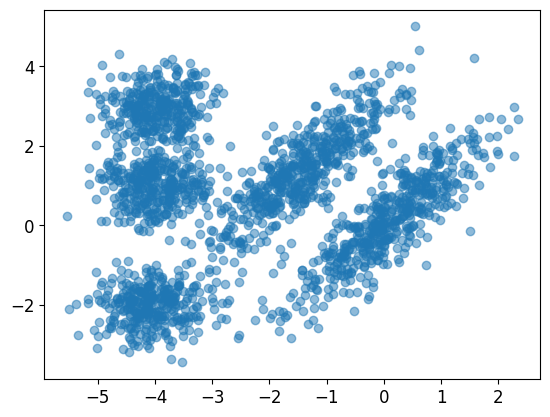

In [67]:
plt.scatter(X[:, 0], X[:, 1], alpha=0.5) 

In [70]:
Ks = range(2, 12)
# inertia = distorsion
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(X) for k in Ks]
inertias = [model.inertia_ for model in kmeans_per_k]

NameError: name 'geron_data' is not defined

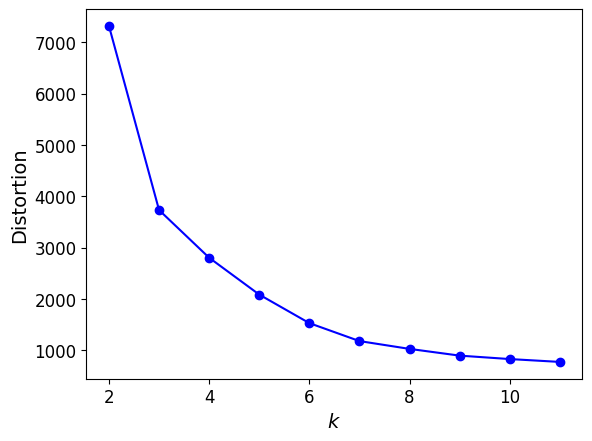

In [71]:
plt.figure()
plt.plot(Ks, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Distortion", fontsize=14)
if geron_data:
    plt.annotate(
        "Elbow",
        xy=(4, inertias[3]),
        xytext=(0.55, 0.55),
        textcoords="figure fraction",
        fontsize=16,
        arrowprops=dict(facecolor="black", shrink=0.1),
    )
# plt.axis([1, 8.5, 0, 1300])
plt.tight_layout()
plt.show()


In [72]:
silhouette_scores = [silhouette_score(X, model.labels_) for model in kmeans_per_k]

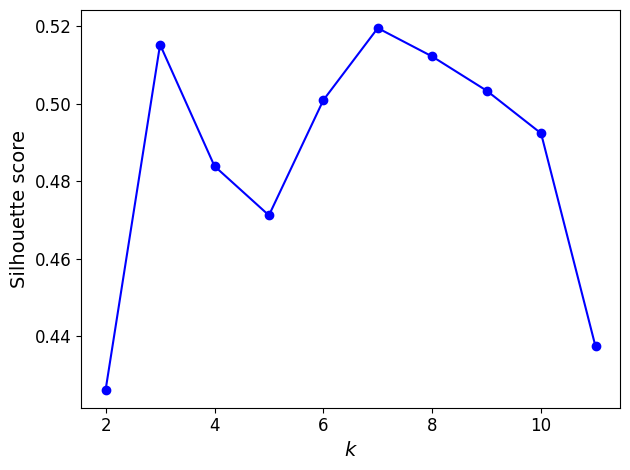

In [73]:
plt.figure()
plt.plot(Ks, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.tight_layout()
plt.show()

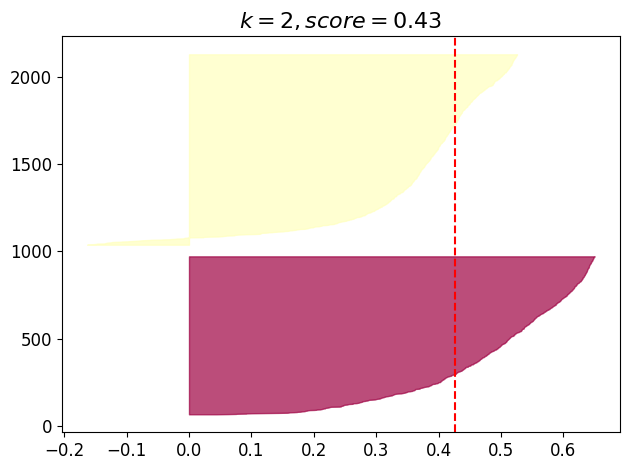

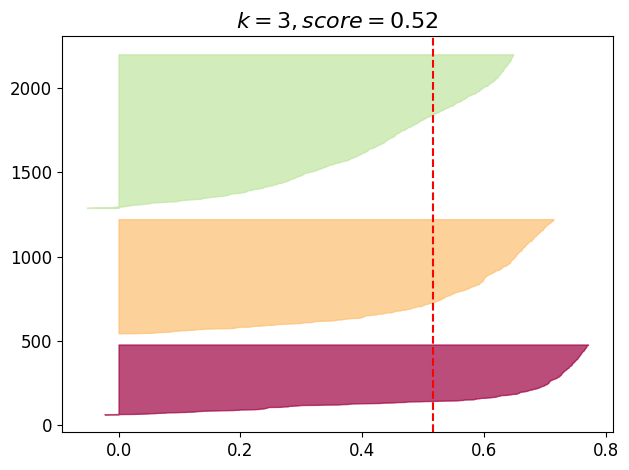

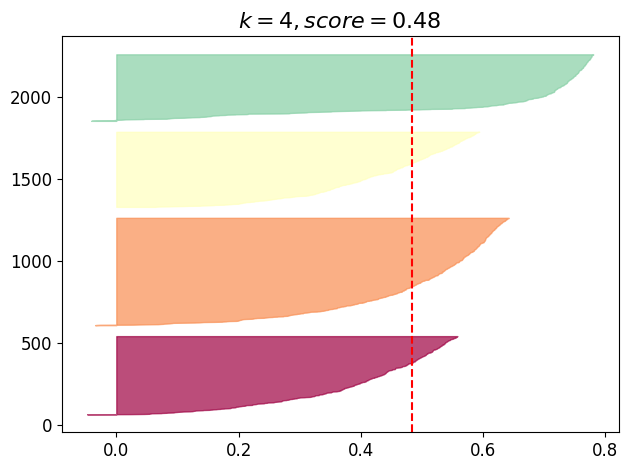

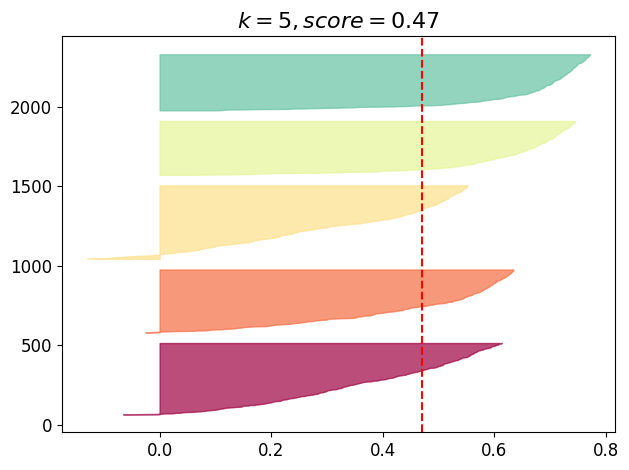

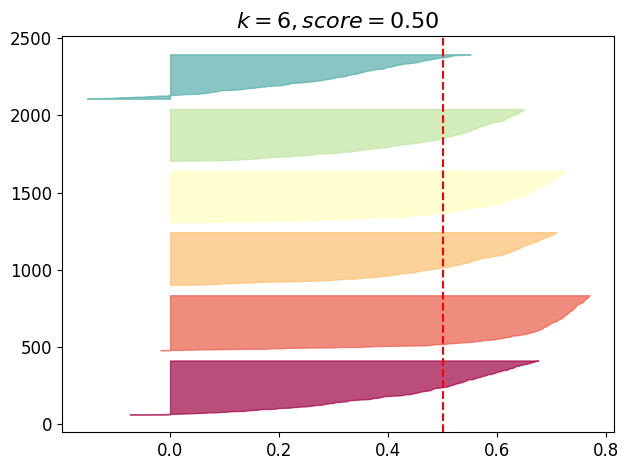

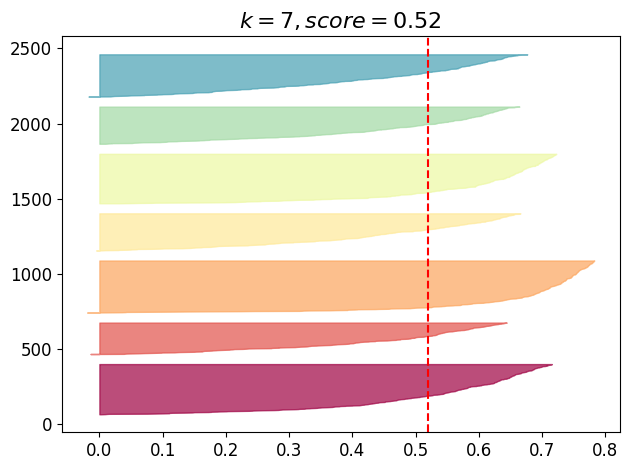

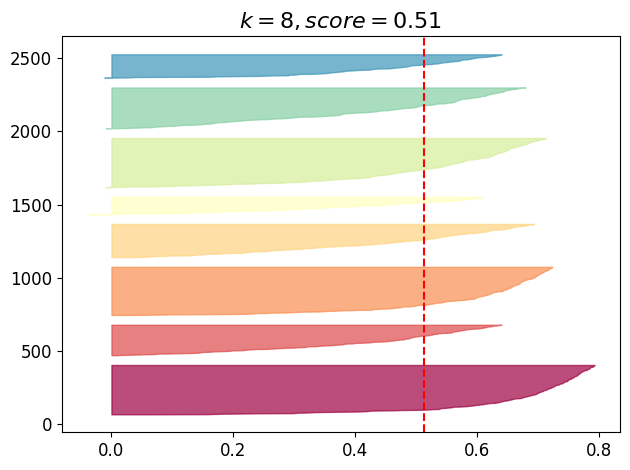

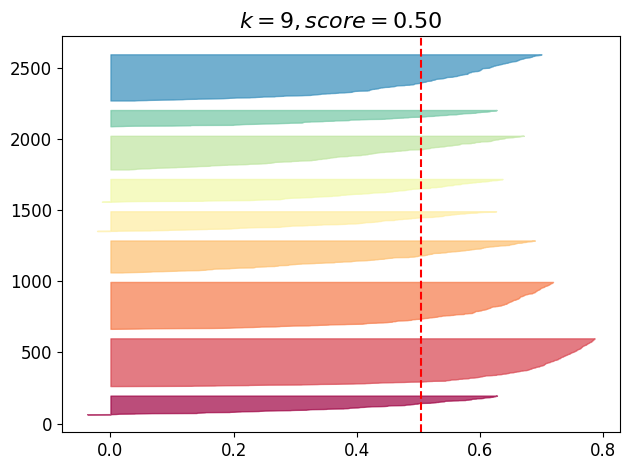

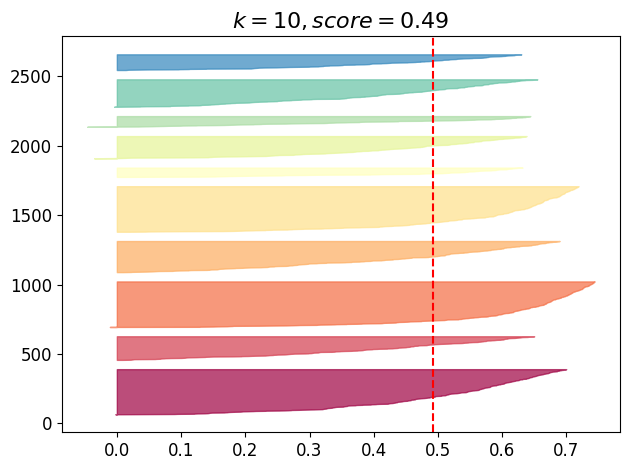

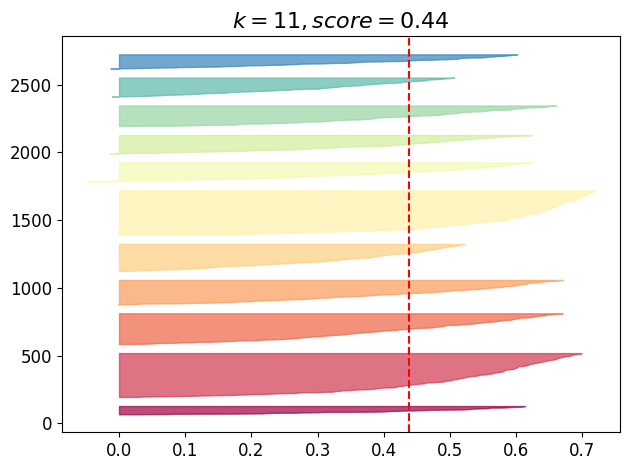

In [74]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import warnings

warnings.filterwarnings("ignore")

def plot_silhouette(model, X):
    mu = model.cluster_centers_
    K, D = mu.shape
    y_pred = model.labels_
    silhouette_coefficients = silhouette_samples(X, y_pred)
    silhouette_scores = silhouette_score(X, model.labels_)
    cmap = cm.get_cmap("Pastel2")
    colors = [cmap(i) for i in range(K)]
    padding = len(X) // 30
    pos = padding
    for i in range(K):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / K)
        # color = colors[i]
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs, facecolor=color, edgecolor=color, alpha=0.7)
        pos += len(coeffs) + padding
    score = silhouette_scores
    plt.axvline(x=score, color="red", linestyle="--")
    plt.title("$k={}, score={:0.2f}$".format(K, score), fontsize=16)


for model in kmeans_per_k:
    K, D = model.cluster_centers_.shape
    plt.figure()
    plot_silhouette(model, X)
    fname = f"kmeans_silhouette_diagram{K}.pdf"
    plt.tight_layout()


---

#### MiniBatches for high N

In [75]:
from sklearn.cluster import MiniBatchKMeans

In [76]:
blob_centers = np.array([[0.2, 2.3], [-1.5, 2.3], [-2.8, 1.8], [-2.8, 2.8], [-2.8, 1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)

In [77]:
from timeit import timeit

K = 50
times = np.empty((K, 2))
inertias = np.empty((K, 2))
for k in range(1, K + 1):
    kmeans_ = KMeans(n_clusters=k, random_state=42)
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    print("\r{}/{}".format(k, 100), end="")
    times[k - 1, 0] = timeit("kmeans_.fit(X)", number=10, globals=globals())
    times[k - 1, 1] = timeit("minibatch_kmeans.fit(X)", number=10, globals=globals())
    inertias[k - 1, 0] = kmeans_.inertia_
    inertias[k - 1, 1] = minibatch_kmeans.inertia_

50/100

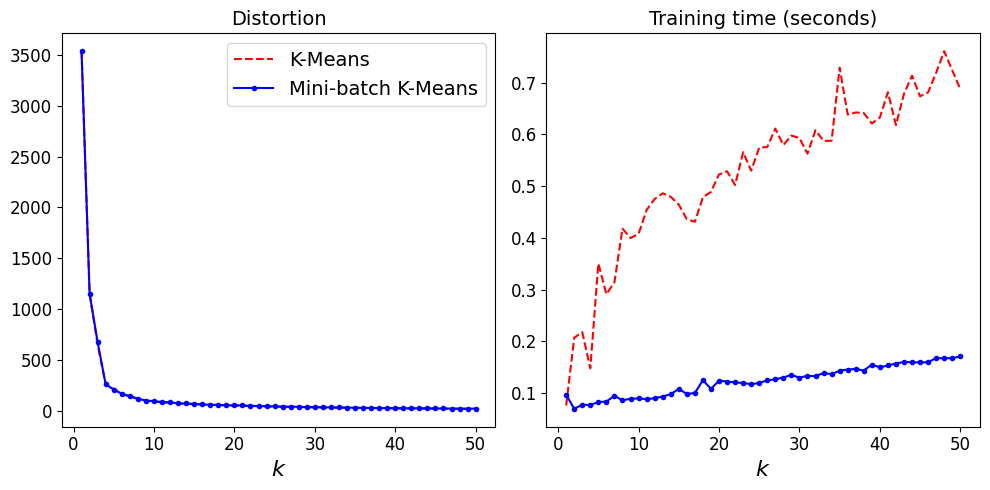

In [78]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(range(1, K + 1), inertias[:, 0], "r--", label="K-Means")
plt.plot(range(1, K + 1), inertias[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Distortion", fontsize=14)
plt.legend(fontsize=14)
# plt.axis([1, K, 0, K])

plt.subplot(122)
plt.plot(range(1, K + 1), times[:, 0], "r--", label="K-Means")
plt.plot(range(1, K + 1), times[:, 1], "b.-", label="Mini-batch K-Means")
plt.xlabel("$k$", fontsize=16)
plt.title("Training time (seconds)", fontsize=14)
# plt.axis([1, K, 0, 6])

plt.tight_layout()
plt.show()

---

### 3.3 Mixture Models

We have seen how the K-means algorithm can be used to cluster data vectors in $\mathbb{R}^{D}$. However, this method assumes that all clusters have the same spherical shape, which is a very restrictive assumption. In addition, K-means assumes that all clusters can be described by Gaussians in the input space, so it cannot be applied to discrete data. By using **mixture models**, we can overcome both of these problems, as we illustrate below.

In [79]:
%run -i 'mixturemodels.py'

In [80]:
K = 5
gm = GaussianMixture(n_components=K,  covariance_type='full', n_init=10, random_state=42)
gm.fit(X)

GaussianMixture(n_components=5, n_init=10, random_state=42)

In [81]:
w = gm.weights_
mu = gm.means_
Sigma = gm.covariances_

In [82]:
resolution = 100
grid = np.arange(-10, 10, 1 / resolution)
xx, yy = np.meshgrid(grid, grid)
X_full = np.vstack([xx.ravel(), yy.ravel()]).T

In [83]:
# score_samples is the log pdf
pdf = np.exp(gm.score_samples(X_full))
pdf_probas = pdf * (1 / resolution) ** 2
print("integral of pdf {}".format(pdf_probas.sum()))

integral of pdf 1.0000000000000429


In [84]:

# Choosing K. Co,mpare to kmeans_silhouette
Ks = range(2, 9)
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X) for k in Ks]

bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

In [85]:

gm_full = GaussianMixture(n_components=K, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=K, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=K, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=K, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

GaussianMixture(covariance_type='diag', n_components=5, n_init=10,
                random_state=42)

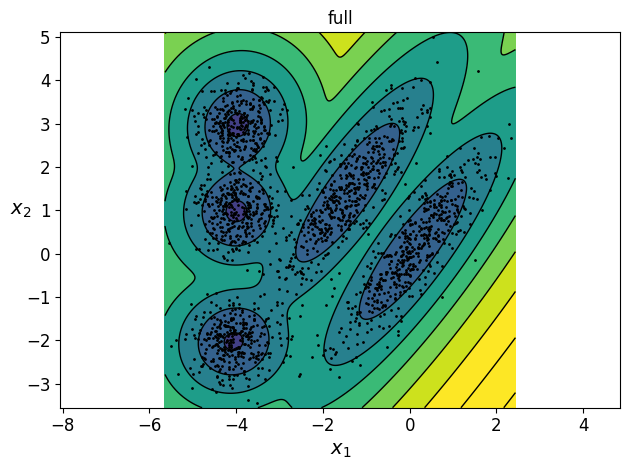

In [86]:
make_plot(gm_full, X, 'full')

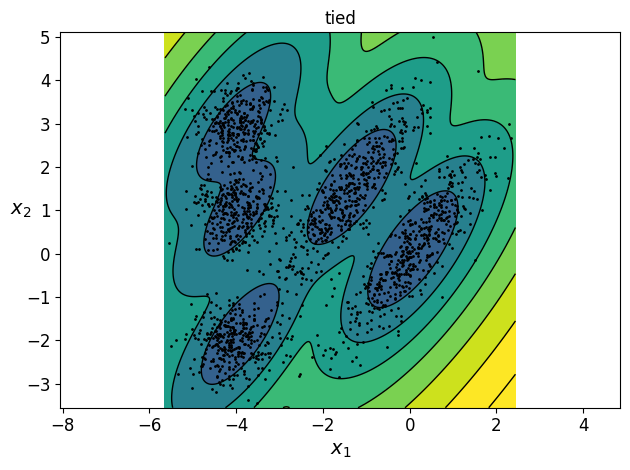

In [88]:
make_plot(gm_tied, X, 'tied')

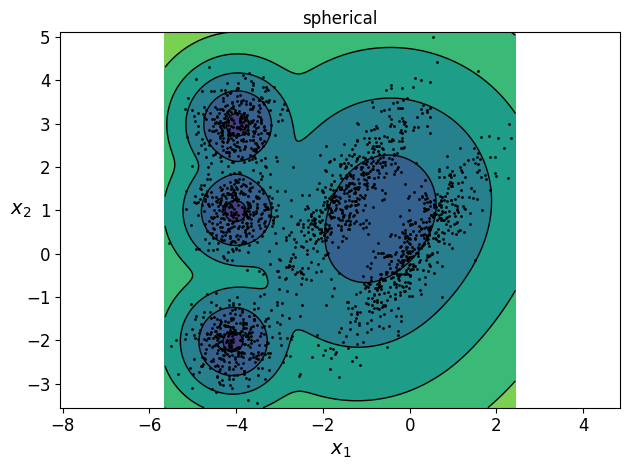

In [89]:
make_plot(gm_spherical, X, 'spherical')

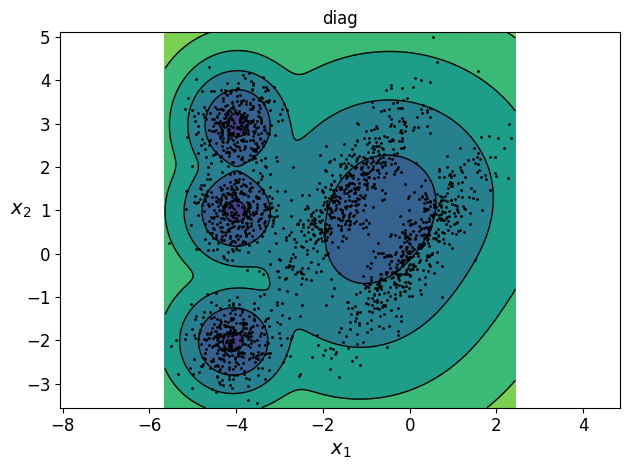

In [91]:
make_plot(gm_diag, X, 'diag')

---

### Links

- [When clustering doesnt make sense](https://towardsdatascience.com/when-clustering-doesnt-make-sense-c6ed9a89e9e6)
- [What is kmeans++](https://www.youtube.com/watch?v=4qJWhvFQb9g&t=0s)
- [Evaluation metrics](https://www.cs.upc.edu/~bejar/URL/material/04-Validation.pdf)